In [12]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.down1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        bn = self.bottleneck(p4)

        up4 = self.upconv4(bn)
        up4 = torch.cat([up4, d4], dim=1)
        up4 = self.up4(up4)

        up3 = self.upconv3(up4)
        up3 = torch.cat([up3, d3], dim=1)
        up3 = self.up3(up3)

        up2 = self.upconv2(up3)
        up2 = torch.cat([up2, d2], dim=1)
        up2 = self.up2(up2)

        up1 = self.upconv1(up2)
        up1 = torch.cat([up1, d1], dim=1)
        up1 = self.up1(up1)

        out = self.final_conv(up1)

        return out


In [13]:
x = torch.randn(4, 1, 256, 256)  # (batch, channels, height, width)
model = UNet()
out = model(x)
print(out.shape)


torch.Size([4, 1, 256, 256])


In [15]:
from torch.utils.data import Dataset
import os
import cv2
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.filenames = sorted(os.listdir(images_dir))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.filenames[idx])

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Normalize and expand dims
        image = image.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0

        image = np.expand_dims(image, axis=0)  # (1, H, W)
        mask = np.expand_dims(mask, axis=0)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)


In [16]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# Paths
train_images_dir = '/kaggle/input/brain-tumour/Brain_tumour/train/images'
train_masks_dir =  '/kaggle/input/brain-tumour/Brain_tumour/train/masks'
val_images_dir =  '/kaggle/input/brain-tumour/Brain_tumour/val/images'
val_masks_dir = '/kaggle/input/brain-tumour/Brain_tumour/val/masks'
test_images_dir =  '/kaggle/input/brain-tumour/Brain_tumour/test/images'
test_masks_dir = '/kaggle/input/brain-tumour/Brain_tumour/test/masks'


# Datasets and Loaders
train_dataset = SegmentationDataset(train_images_dir, train_masks_dir)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir)
test_dataset = SegmentationDataset(test_images_dir, test_masks_dir)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)
print(device)



cuda


In [ ]:
"""
# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
num_epochs = 40

for epoch in range(40):
    print(epoch)
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(val_loader):.4f}")

# Save model
torch.save(model.state_dict(), 'unet_segmentation.pth')
print("✅ Model saved as 'unet_segmentation.pth'") """


In [17]:
import torch

# Define your UNet model class again (or import it if you have it in another file)
model = UNet()  # Make sure UNet() matches the model you trained
model.load_state_dict(torch.load('/kaggle/input/unet-segementation/unet_segmentation.pth'))
model.eval()  # Set the model to evaluation mode
print("✅ Model loaded from 'unet_segmentation.pth'")


✅ Model loaded from 'unet_segmentation.pth'


/tmp/ipykernel_31/4132015482.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/unet-segementation/unet_segmentation.pth'))


In [18]:
import torch.nn.functional as F

def dice_coef(preds, targets, smooth=1e-5):
    preds = preds.contiguous()
    targets = targets.contiguous()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def precision(preds, targets, smooth=1e-5):
    preds = preds.contiguous()
    targets = targets.contiguous()
    tp = (preds * targets).sum(dim=(1, 2, 3))
    fp = (preds * (1 - targets)).sum(dim=(1, 2, 3))
    prec = (tp + smooth) / (tp + fp + smooth)
    return prec.mean()

def recall(preds, targets, smooth=1e-5):
    preds = preds.contiguous()
    targets = targets.contiguous()
    tp = (preds * targets).sum(dim=(1, 2, 3))
    fn = ((1 - preds) * targets).sum(dim=(1, 2, 3))
    rec = (tp + smooth) / (tp + fn + smooth)
    return rec.mean()

def iou(preds, targets, smooth=1e-5):
    preds = preds.contiguous()
    targets = targets.contiguous()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    total = (preds + targets).sum(dim=(1, 2, 3))
    union = total - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()


In [19]:
def evaluate(model, dataloader, device):
    model.to(device)
    model.eval()
    
    dice_scores = []
    precision_scores = []
    recall_scores = []
    iou_scores = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()  # Threshold to binary mask
            
            dice_scores.append(dice_coef(preds, masks))
            precision_scores.append(precision(preds, masks))
            recall_scores.append(recall(preds, masks))
            iou_scores.append(iou(preds, masks))
    
    print(f"Dice Coefficient: {torch.stack(dice_scores).mean().item():.4f}")
    print(f"Precision: {torch.stack(precision_scores).mean().item():.4f}")
    print(f"Recall: {torch.stack(recall_scores).mean().item():.4f}")
    print(f"IoU: {torch.stack(iou_scores).mean().item():.4f}")


In [20]:
import torch
import random
import matplotlib.pyplot as plt

def evaluate(model, train_loader, val_loader, device):
    model.to(device)
    model.eval()
    
    dice_scores = []
    precision_scores = []
    recall_scores = []
    iou_scores = []
    
    random_train_batch = random.choice(list(train_loader))
    random_val_batch = random.choice(list(val_loader))

    with torch.no_grad():
        # Evaluate on validation set
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()  # Threshold to binary mask
            
            dice_scores.append(dice_coef(preds, masks))
            precision_scores.append(precision(preds, masks))
            recall_scores.append(recall(preds, masks))
            iou_scores.append(iou(preds, masks))
    print(f"Train Data:")
    print(f"Dice Coefficient: {torch.stack(dice_scores).mean().item():.4f}")
    print(f"Precision: {torch.stack(precision_scores).mean().item():.4f}")
    print(f"Recall: {torch.stack(recall_scores).mean().item():.4f}")
    print(f"IoU: {torch.stack(iou_scores).mean().item():.4f}")
    dice_scores = []
    precision_scores = []
    recall_scores = []
    iou_scores = []
    with torch.no_grad():
        # Evaluate on validation set
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()  # Threshold to binary mask
            
            dice_scores.append(dice_coef(preds, masks))
            precision_scores.append(precision(preds, masks))
            recall_scores.append(recall(preds, masks))
            iou_scores.append(iou(preds, masks))
    print(f"Test Data:")
    print(f"Dice Coefficient: {torch.stack(dice_scores).mean().item():.4f}")
    print(f"Precision: {torch.stack(precision_scores).mean().item():.4f}")
    print(f"Recall: {torch.stack(recall_scores).mean().item():.4f}")
    print(f"IoU: {torch.stack(iou_scores).mean().item():.4f}")
    
    # Plot random train batch
    print("\nRandom Training Batch Samples:")
    plot_batch(model, random_train_batch, device)
    
    # Plot random validation batch
    print("\nRandom Testing Batch Samples:")
    plot_batch(model, random_val_batch, device)


def plot_batch(model, batch, device, num_images=4):
    images, masks = batch
    images = images.to(device)
    masks = masks.to(device)
    
    model.eval()
    with torch.no_grad():
        preds = model(images)
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float()
    
    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()
    
    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].permute(1, 2, 0).squeeze(), cmap='gray')
        axes[i, 0].set_title('Input Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(preds[i].squeeze(), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


Train Data:
Dice Coefficient: 0.9788
Precision: 0.9830
Recall: 0.9751
IoU: 0.9589
Test Data:
Dice Coefficient: 0.6230
Precision: 0.8208
Recall: 0.6032
IoU: 0.5431

Random Training Batch Samples:


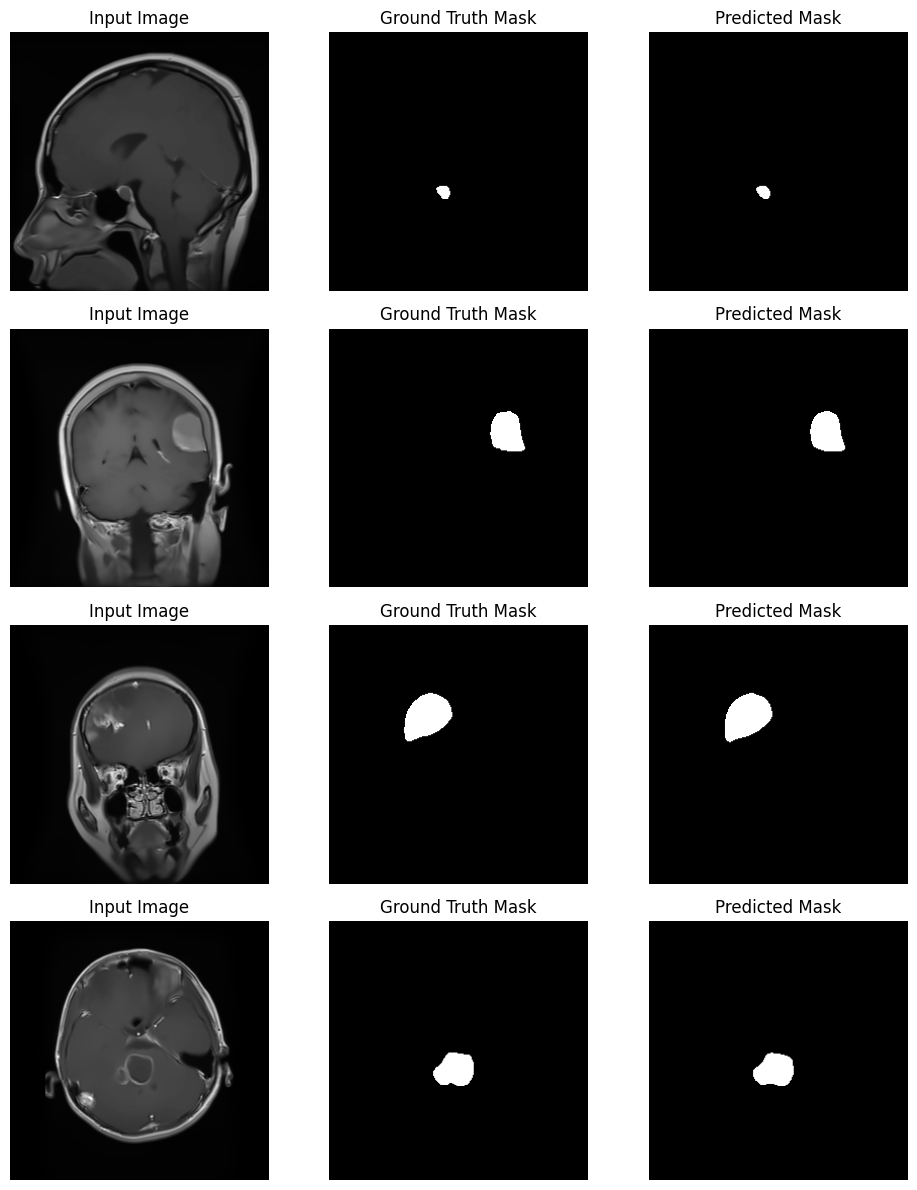


Random Validation Batch Samples:


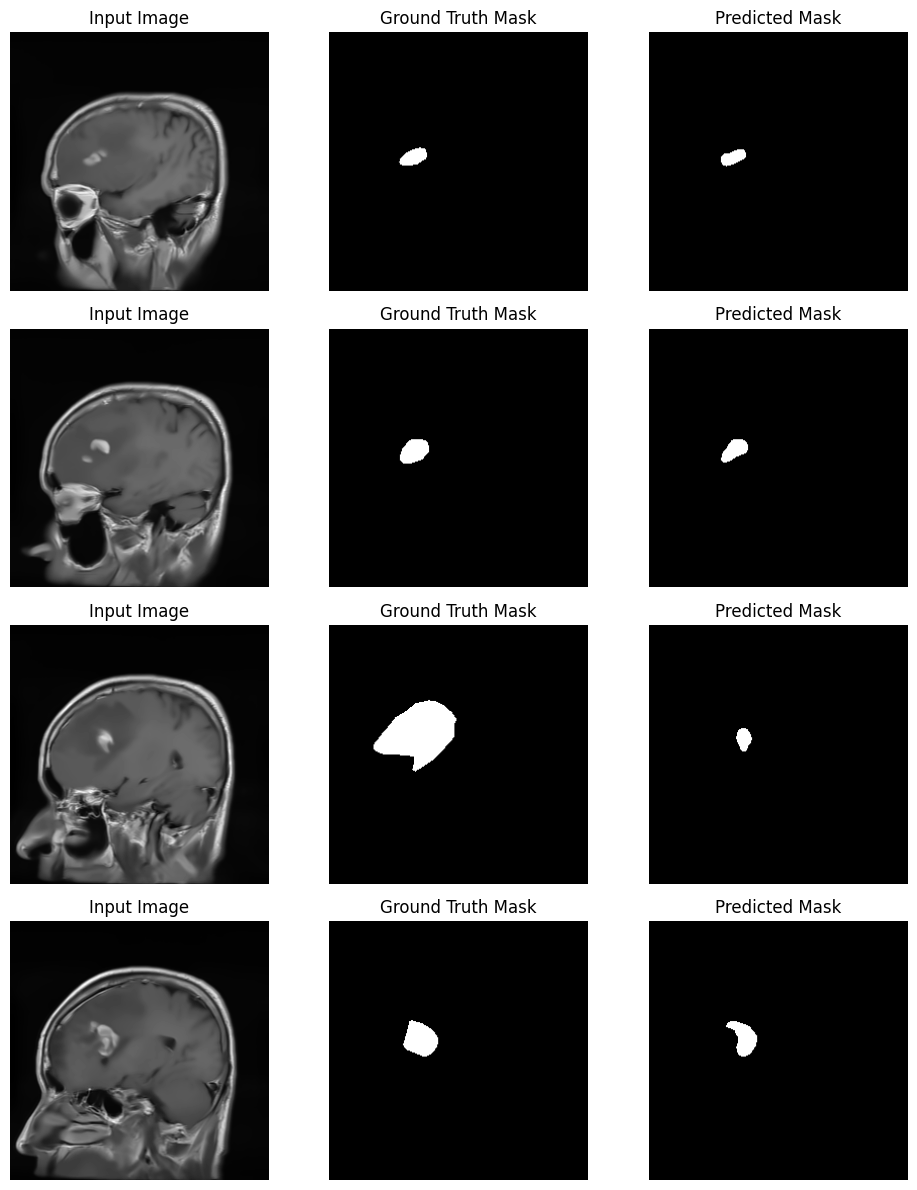

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example:
evaluate(model, train_loader,test_loader, device)
#evaluate(model, val_loader, device)
